In [ ]:
!pip install umap-learn
!pip install lightfm

     |████████████████████████████████| 81kB 4.2MB/s 
     |████████████████████████████████| 1.2MB 10.9MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=2d966904672269a8d2ae351c1ece5ec78b5595ed18700270a9ae694cfbf178bc
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=c449c4e7c9f10c3491b4ca060bf8c96654bb954a239a3cfeb45f31d087f28edb
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent
     |████████████████████████████████| 317kB 11.7MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=697400 sha256=98c230fedbc53f3f0925226862e10693f25b6d9be3d81be9f9ef084c7c3a12b9
  Stored in directory: /root/.cache/pip/wheels/c6/64/d4/673c7277f71ac4c5ad4835b94708c01b653ef2d

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
from google.colab import files
from sklearn.model_selection import cross_val_score
import time
import datetime
from sklearn.model_selection import KFold
from tqdm import tqdm
import random
import umap.umap_ as umap
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn import preprocessing
import spacy
import gzip
import json
import gc
import matplotlib.pyplot as plt 

import pandas as pd
from scipy.sparse import csr_matrix
import numpy as np

from matplotlib.gridspec import GridSpec
import seaborn as sns
%matplotlib inline
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm import LightFM
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with gzip.open("/content/drive/MyDrive/Проект 'рекомендательная система для магазина'/Electronics_5.json.gz") as f:
    s=sum(1 for _ in f)
s

6739590

In [ ]:
i=0
electronics = []
with gzip.open("/content/drive/MyDrive/Проект 'рекомендательная система для магазина'/Electronics_5.json.gz") as f:
    for l in f:
        electronics.append(json.loads(l.strip()))
        i+=1
        if i>0.002*s:
            break

In [ ]:
product_df = pd.DataFrame(electronics)
del electronics
gc.collect()
product_df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,67,True,"09 18, 1999",AAP7PPBU72QFM,0151004714,{'Format:': ' Hardcover'},D. C. Carrad,This is the best novel I have read in 2 or 3 y...,A star is born,937612800,NaN
1,3.0,5,True,"10 23, 2013",A2E168DTVGE6SV,0151004714,{'Format:': ' Kindle Edition'},Evy,"Pages and pages of introspection, in the style...",A stream of consciousness novel,1382486400,NaN
2,5.0,4,False,"09 2, 2008",A1ER5AYS3FQ9O3,0151004714,{'Format:': ' Paperback'},Kcorn,This is the kind of novel to read when you hav...,I'm a huge fan of the author and this one did ...,1220313600,NaN
3,5.0,13,False,"09 4, 2000",A1T17LMQABMBN5,0151004714,{'Format:': ' Hardcover'},Caf Girl Writes,What gorgeous language! What an incredible wri...,The most beautiful book I have ever read!,968025600,NaN
4,3.0,8,True,"02 4, 2000",A3QHJ0FXK33OBE,0151004714,{'Format:': ' Hardcover'},W. Shane Schmidt,I was taken in by reviews that compared this b...,A dissenting view--In part.,949622400,NaN


In [ ]:
with gzip.open("/content/drive/MyDrive/Проект 'рекомендательная система для магазина'/meta_Electronics.json.gz") as f:
    s=sum(1 for _ in f)
s

In [ ]:

i=0
electronics = []
with gzip.open("/content/drive/MyDrive/Проект 'рекомендательная система для магазина'/meta_Electronics.json.gz") as f:
    for l in f:
        electronics.append(json.loads(l.strip()))
        i+=1
        if i>0.1*s:
            break

In [ ]:
purchase_df = pd.DataFrame(electronics)
del electronics
gc.collect()
purchase_df.head()

,category,tech1,description,fit,title,also_buy,image,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,details
0,"[Electronics, Camera &amp; Photo, Video Survei...",,[The following camera brands and models have b...,,Genuine Geovision 1 Channel 3rd Party NVR IP S...,[],[https://images-na.ssl-images-amazon.com/image...,,GeoVision,"[Genuine Geovision 1 Channel NVR IP Software, ...","[>#3,092 in Tools &amp; Home Improvement &gt; ...",[],Camera &amp; Photo,,"January 28, 2014",$65.00,0011300000,NaN
1,"[Electronics, Camera &amp; Photo]",,[This second edition of the Handbook of Astron...,,"Books ""Handbook of Astronomical Image Processi...",[0999470906],[https://images-na.ssl-images-amazon.com/image...,,33 Books Co.,[Detailed chapters cover these fundamental top...,"[>#55,933 in Camera &amp; Photo (See Top 100 i...","[0943396670, 1138055360, 0999470906]",Camera &amp; Photo,,"June 17, 2003",,0043396828,NaN
2,"[Electronics, eBook Readers &amp; Accessories,...",,[A zesty tale. (Publishers Weekly)<br /><br />...,,One Hot Summer,"[0425167798, 039914157X]",[],,Visit Amazon's Carolina Garcia Aguilera Page,[],"3,105,177 in Books (",[],Books,,,$11.49,0060009810,NaN
3,"[Electronics, eBook Readers & Accessories, eBo...",,[],,Hurray for Hattie Rabbit: Story and pictures (...,"[0060219521, 0060219580, 0060219394]",[],,Visit Amazon's Dick Gackenbach Page,[],"2,024,298 in Books (","[0060219521, 0060219475, 0060219394]",Books,,,.a-section.a-spacing-mini{margin-bottom:6px!im...,0060219602,NaN
4,"[Electronics, eBook Readers & Accessories, eBo...",,[&#8220;sex.lies.murder.fame. is brillllli&#82...,,sex.lies.murder.fame.: A Novel,[],[],,Visit Amazon's Lolita Files Page,[],"3,778,828 in Books (",[],Books,,,$13.95,0060786817,NaN


In [ ]:
product_df = product_df.sort_values(by=['unixReviewTime'])

In [ ]:
interactions_selected = pd.read_csv("/content/drive/MyDrive/Проект 'рекомендательная система для магазина'/Electronics.csv", names = ["asin", "reviewerID", "overall", "time"])
interactions_selected = interactions_selected.sort_values(by=['time'])
interactions_selected = interactions_selected.drop(["time"], axis=1)
interactions_selected.head()

,asin,reviewerID,overall
133,0312171048,A3B12RM18TB8OQ,5.0
17551137,0441865704,A2CT25FY12PYNF,5.0
18097320,B00000DM96,AFHLJPG5ZIMNO,5.0
132,0312171048,A1BAGB0MH4ZVO1,3.0
31692,B00000JFMK,A2S7NL1Q1I1QMX,4.0


In [ ]:
product_df_selected = product_df[["asin", "verified"]]
print(len(product_df_selected))
product_df_selected = product_df_selected.drop_duplicates()
print(len(product_df_selected))
product_df_selected["overall_mean"]=np.zeros(len(product_df_selected))
product_df_selected["count"]=np.zeros(len(product_df_selected))
product_df_selected = product_df_selected.reset_index().drop(["index"],axis=1)
product_df_selected.head()

134792
4592


,asin,verified,overall_mean,count
0,B00000JBAT,False,0.0,0.0
1,B00000J40U,False,0.0,0.0
2,B00000J3NF,False,0.0,0.0
3,B00000JDKU,False,0.0,0.0
4,B00000JFMK,False,0.0,0.0


In [ ]:
j=0
for i in tqdm(product_df_selected.asin.values.tolist()):
    if i in interactions_selected.asin.values.tolist():
        lst = interactions_selected[interactions_selected["asin"]==i]["overall"].values.tolist()
        product_df_selected.at[j, 'overall_mean'] = sum(lst)/len(lst)
        product_df_selected.at[j, 'count'] = len(lst)
    j+=1    
product_df_selected['overall_mean'] = product_df_selected['overall_mean'].apply(lambda x: round(x*2)/2)
product_df_selected['count'] = product_df_selected['count'].apply(lambda x: int(round(x/5.0)*5))
product_df_selected 

100%|██████████| 4592/4592 [1:45:15<00:00,  1.38s/it]


,asin,verified,overall_mean,count
0,B00000JBAT,False,3.5,120
1,B00000J40U,False,4.5,40
2,B00000J3NF,False,4.5,60
3,B00000JDKU,False,4.0,25
4,B00000JFMK,False,4.5,65
...,...,...,...,...
4587,B00006JHZ0,False,4.5,150
4588,B000051TN6,True,4.0,55
4589,B00006LUA9,False,4.5,105
4590,B000068O1I,False,4.5,70


In [ ]:
product_df_selected = pd.read_csv("/content/drive/MyDrive/Проект 'рекомендательная система для магазина'/data_csv.csv")
product_df_selected = product_df_selected.drop(["Unnamed: 0"],axis=1)
product_df_selected.head()

,asin,verified,overall_mean,count
0,B00000JBAT,False,3.5,120
1,B00000J40U,False,4.5,40
2,B00000J3NF,False,4.5,60
3,B00000JDKU,False,4.0,25
4,B00000JFMK,False,4.5,65


In [ ]:
data_file = open("data_csv.csv",'w')
product_df_selected.to_csv(data_file)
files.download("data_csv.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#interactions_selected.shape
interactions_selected = interactions_selected[interactions_selected['reviewerID'].isin(
    random.sample(list(interactions_selected['reviewerID'].unique()), k=2000))]

interactions_selected.sample(10)

,asin,reviewerID,overall
10596948,B00HQWZ6UY,A24ZL2O7MO5F2S,5.0
17852166,B000MUWZ4C,A1241RSXXBXDCX,4.0
13112754,B00PKSEYX6,A1A3ZBEJ6A6O4J,5.0
19782940,B00M539W7M,A1WUUFRNJ2DB9N,5.0
13166141,B00PXGETE4,A3KK38DKBJHCJS,5.0
4510492,B004DYP5OK,A15PDP2OPYJ8Z7,4.0
20083055,B00ST8GT8W,AW98V7GHP91JJ,2.0
1599790,B000Q87LM6,A35P91TY21SH7D,5.0
17543330,B01HEUUVP2,A2K80FEVMA676U,5.0
11373098,B00JT1OLO2,AIRDQUXG2SKY5,5.0


In [ ]:
books_metadata_selected_transformed = pd.get_dummies(product_df_selected, columns = ["verified","overall_mean", "count"])

books_metadata_selected_transformed = books_metadata_selected_transformed.sort_values('asin').reset_index().drop('index', axis=1)
books_metadata_selected_transformed.head(5)

,asin,verified_False,verified_True,overall_mean_1.5,overall_mean_2.0,overall_mean_2.5,overall_mean_3.0,overall_mean_3.5,overall_mean_4.0,overall_mean_4.5,overall_mean_5.0,count_10,count_15,count_20,count_25,count_30,count_35,count_40,count_45,count_50,count_55,count_60,count_65,count_70,count_75,count_80,count_85,count_90,count_95,count_100,count_105,count_110,count_115,count_120,count_125,count_130,count_135,count_140,count_145,count_150,...,count_1270,count_1280,count_1290,count_1295,count_1325,count_1365,count_1380,count_1395,count_1435,count_1450,count_1465,count_1470,count_1480,count_1525,count_1555,count_1665,count_1780,count_1815,count_1850,count_1875,count_1890,count_1895,count_1925,count_2045,count_2205,count_2370,count_2420,count_2550,count_2565,count_2580,count_2715,count_2785,count_2810,count_2925,count_3405,count_3490,count_4205,count_4225,count_4710,count_5705
0,0101635370,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0101635370,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0151004714,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0151004714,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0380709473,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
books_metadata_csr = csr_matrix(books_metadata_selected_transformed.drop('asin', axis=1).values)
books_metadata_csr

<4592x202 sparse matrix of type '<class 'numpy.uint8'>'
	with 13776 stored elements in Compressed Sparse Row format>

In [ ]:
user_book_interaction = pd.pivot_table(interactions_selected, index='reviewerID', columns='asin', values='overall')

# fill missing values with 0
user_book_interaction = user_book_interaction.fillna(0)

user_book_interaction

asin,0972683275,1400501717,140053271X,1495443043,1935009257,9573212919,9983891212,B00000JDH6,B00000K4KH,B00001WRSJ,B00002EQCS,B00002K14F,B0000326O3,B00004SABB,B00004SDRZ,B00004SPBX,B00004T8R2,B00004THAU,B00004UDFI,B00004UDQ1,B00004VXNF,B00004W1U8,B00004Z5M1,B00004Z72A,B00004Z75E,B00004ZCJI,B00004ZCJJ,B00004ZCKX,B000050FB6,B00005119M,B000053HH5,B000059Y4N,B00005ATMB,B00005ATMG,B00005JDDZ,B00005K47X,B00005LEN4,B00005N6KG,B00005NBQH,B00005NHH8,...,B01GI6EX4I,B01GJO99DY,B01GLCI5AM,B01GLFK7MI,B01GN00OO2,B01GNNPJK8,B01GNQIIYO,B01GPDIYJO,B01GT3T9V2,B01GUO64LS,B01GUO65MQ,B01GWYNIPQ,B01GXV99CO,B01GYOGPEU,B01H14SFRM,B01H18X9EM,B01H1S31JA,B01H31E036,B01H36MZZ6,B01H3CQ64Q,B01H3D2BVW,B01H44UI7E,B01H49G3BO,B01H4YTH6W,B01H5KKQTM,B01H6I3YGK,B01H6ONLO4,B01H747V80,B01H7EK9WK,B01HBE71YA,B01HCG2174,B01HCGZBWG,B01HCP95NS,B01HCT3GCU,B01HEIEMQI,B01HEU1R82,B01HEUUVP2,B01HEZK95Y,B01HFMT3LW,B01HJ0BJNA
reviewerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A103D4NHXIMPXZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A103IF4T13S9RD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1043171NOIEXI8REA7V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10559VK7LW5SK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105RI8VT47X3C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZL1UY5AK1KGE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZRIUJELKKML,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZU9H6MDIVTRZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
user_id = list(user_book_interaction.index)
user_dict = {}
counter = 0 
for i in user_id:
    user_dict[i] = counter
    counter += 1

In [ ]:
# convert to csr matrix
user_book_interaction_csr = csr_matrix(user_book_interaction.values)
user_book_interaction_csr

<2000x3777 sparse matrix of type '<class 'numpy.float64'>'
	with 4107 stored elements in Compressed Sparse Row format>

In [ ]:
model_FM = LightFM(loss='warp',
                random_state=2016,
                learning_rate=0.90,
                no_components=150,
                user_alpha=0.000005)

model_FM = model_FM.fit(user_book_interaction_csr,
                  epochs=100,
                  num_threads=16, verbose=False)

In [ ]:
def sample_recommendation_user(model, interactions, user_id, user_dict, 
                              threshold = 0,nrec_items = 5, show = True):
    
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items), item_features=books_metadata_csr))
    scores.index = interactions.columns
    scores = pd.Series(scores.sort_values(ascending=False))
    asin = list(scores.index)
    scores=list(scores.values)
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index).sort_values(ascending=False))

    for i in known_items:
        if i in asin:
            ind = asin.index(i)
            asin.pop(ind)
            scores.pop(ind)
    if show == True:
        print ("User: " + str(user_id))
        print("Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + i)
            counter+=1

        print("\n Recommended Items:")
        counter = 1
        lst = []
        for i,j in zip(asin, scores):
            if counter<=nrec_items:
                print(str(counter) + '- ' + i+ ":"+str(j))
                counter+=1
            lst.append([i,j])
    return lst

In [ ]:
user_dict.keys()

dict_keys(['A103D4NHXIMPXZ', 'A103IF4T13S9RD', 'A1043171NOIEXI8REA7V', 'A10559VK7LW5SK', 'A105RI8VT47X3C', 'A107RCDD5CPP53', 'A108IZ8TDLJQI2', 'A108QRDUFRBX0R', 'A10BDJZPUY8PU2', 'A10CY4YCACX3JK', 'A10LMRY2XP9SKN', 'A10P1UB769E59J', 'A10PAOPS65GIKY', 'A10PZACG60E0WK', 'A10QNNTGHOY22I', 'A10QQ4TVKXIGJ5', 'A10SJ1H094Q52K', 'A110H78XZN4GC4', 'A1114YKDKDI8MD', 'A11B5C17PS7CKB', 'A11E3G01L7OHVM', 'A11JA3YPEES30E', 'A11JV85WGZXJE0', 'A11NZ8TKLO5B6E', 'A11OSU3XES2M1C', 'A11RNVQIYIC2OC', 'A11TOD6OEVENBG', 'A11VFRBNF3R0FT', 'A11W5YNTWBZECB', 'A121UL36M461LN', 'A122X7AGV9AT21', 'A123XIBOAHW3YD', 'A1241RSXXBXDCX', 'A12BK1ZW20XFE6', 'A12CGP9JK1K04C', 'A12IZXUETMXTIS', 'A12JWQRMWWPTND', 'A12N3VD5L4MLO2', 'A12N6VWP20Z1SG', 'A12RJ4X4QS5BTF', 'A12Y16VVLFV8A1', 'A130GI7WOYNATZ', 'A136AKAOCTLEAE', 'A13734OAK7KHEJ', 'A139JBN9047YXT', 'A13EW0S7PCRPPN', 'A13FJO5NMI8P38', 'A13GHWRI79J813', 'A13K8IUEPYYAMH', 'A13KNFRQD3UZ71', 'A13M6BDQ67WMHI', 'A13MLOAWDF0VBO', 'A13NCURKP03XOU', 'A13OJKDJ06QOE5', 'A13QD8TEJF

In [ ]:
answer_light = sample_recommendation_user(model_FM, user_book_interaction, 'A103D4NHXIMPXZ', user_dict)
answer_light

User: A103D4NHXIMPXZ
Known Likes:
1- B00N32IC0W

 Recommended Items:
1- B004LEAYXY:148579710000.0
2- B004LCKVDE:148405220000.0
3- B0169VM0CY:25901023000.0
4- B00B99JUBQ:25892213000.0
5- B004ZGN6MY:25892213000.0


[['B004LEAYXY', 148579710000.0],
 ['B004LCKVDE', 148405220000.0],
 ['B0169VM0CY', 25901023000.0],
 ['B00B99JUBQ', 25892213000.0],
 ['B004ZGN6MY', 25892213000.0],
 ['B007IL764W', 25892213000.0],
 ['B008VQ8IKY', 25892213000.0],
 ['B00AT73OUM', 25892213000.0],
 ['B001EJJ2UU', 25892213000.0],
 ['B00E0WQWKG', 25864892000.0],
 ['B00CIDFP70', 25864892000.0],
 ['B00CHYKVPQ', 25855132000.0],
 ['B00GFHQSZI', 25855132000.0],
 ['B00T9QONOU', 25855132000.0],
 ['B00006HRJR', 25855132000.0],
 ['B00166JB7A', 25855132000.0],
 ['B016A3BKI6', 25726472000.0],
 ['B007IIUNLI', 25717664000.0],
 ['B008W59QZK', 25717664000.0],
 ['B00BB0ZTM2', 25717664000.0],
 ['B001EJN9OA', 25717664000.0],
 ['B004ZEZC14', 25717664000.0],
 ['B00ATLJEXY', 25717664000.0],
 ['B00E0W4U6O', 25690327000.0],
 ['B00CI3BIWQ', 25690327000.0],
 ['B00006G33K', 25680572000.0],
 ['B0016AQ930', 25680572000.0],
 ['B00CEZQ8FA', 25680572000.0],
 ['B00GG5CF74', 25680572000.0],
 ['B00TAD56DE', 25680572000.0],
 ['B0055BJBCM', 17673990000.0],
 ['B00

In [ ]:
answer_light_trans = [x[1] for x in answer_light]
normalized_answer_light = preprocessing.normalize([answer_light_trans], norm='max')

normalized_answer_light =  normalized_answer_light.reshape(-1)*(1-coeff)

In [ ]:
for i in range(len(answer_light)):
    answer_light[i][1] = normalized_answer_light[i]
answer_light 

[['B004LEAYXY', 0.875],
 ['B004LCKVDE', 0.8739724142220187],
 ['B0169VM0CY', 0.15253357855348124],
 ['B00B99JUBQ', 0.15248169270821274],
 ['B004ZGN6MY', 0.15248169270821274],
 ['B007IL764W', 0.15248169270821274],
 ['B008VQ8IKY', 0.15248169270821274],
 ['B00AT73OUM', 0.15248169270821274],
 ['B001EJJ2UU', 0.15248169270821274],
 ['B00E0WQWKG', 0.15232080075658982],
 ['B00CIDFP70', 0.15232080075658982],
 ['B00CHYKVPQ', 0.15226331866952578],
 ['B00GFHQSZI', 0.15226331866952578],
 ['B00T9QONOU', 0.15226331866952578],
 ['B00006HRJR', 0.15226331866952578],
 ['B00166JB7A', 0.15226331866952578],
 ['B016A3BKI6', 0.1515056309495218],
 ['B007IIUNLI', 0.15145375716511925],
 ['B008W59QZK', 0.15145375716511925],
 ['B00BB0ZTM2', 0.15145375716511925],
 ['B001EJN9OA', 0.15145375716511925],
 ['B004ZEZC14', 0.15145375716511925],
 ['B00ATLJEXY', 0.15145375716511925],
 ['B00E0W4U6O', 0.15129276872656883],
 ['B00CI3BIWQ', 0.15129276872656883],
 ['B00006G33K', 0.15123532282210259],
 ['B0016AQ930', 0.1512353228

In [ ]:
random.shuffle(user_id)

# извлечём 90% для трейна
users_train = [user_id[i] for i in range(round(0.9*len(user_id)))]

# разделим на трейнсет и тестсет
train_df = interactions_selected[interactions_selected['reviewerID'].isin(users_train)]
validation_df = interactions_selected[~interactions_selected['reviewerID'].isin(users_train)]
print(len(train_df), len(validation_df))

3776 410


In [ ]:
# Листы для историй покупок покупателей
purchases_train = {}

for i in tqdm(users_train):
    temp = train_df[train_df["reviewerID"] == i]["asin"].tolist()
    purchases_train[i] = temp

100%|██████████| 1800/1800 [00:02<00:00, 811.68it/s]


In [ ]:
purchases_val = {}

for i in tqdm(validation_df['reviewerID'].unique()):
    temp = validation_df[validation_df["reviewerID"] == i]["asin"].tolist()
    purchases_val[i] = temp

100%|██████████| 200/200 [00:00<00:00, 1651.10it/s]


In [ ]:
asin_unique = len(set(list(train_df["asin"].unique())+list(validation_df['asin'].unique())))
asin_unique

3777

In [ ]:
lens = []
l = list(purchases_train.values())+list(purchases_val.values())
for i in l:
    lens.append(len(i))
lens = sorted(list(set(lens)))
lens = list(set(list(map(lambda x: round(x/5)*5, lens))))
lens

[0, 5, 40, 10, 15, 20, 25, 30]

In [ ]:
lens_norm = preprocessing.normalize([lens], norm='max')
lens_norm = lens_norm.reshape(-1)

In [ ]:
dicti = {}
for i in range(len(lens)):
    dicti[lens[i]]=lens_norm[i]
dicti

{0: 0.0, 5: 0.125, 10: 0.25, 15: 0.375, 20: 0.5, 25: 0.625, 30: 0.75, 40: 1.0}

In [ ]:
#purchases_val.keys()
id = 'A2930CXHUOBFEY'
size = len(purchases_val[id])
size = round(size/5)*5
coeff = dicti[size]
coeff

0.125

In [ ]:
model_wv = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, 
                 alpha=0.03, min_alpha=0.0007, min_count=1)

model_wv.build_vocab(list(purchases_train.values())+list(purchases_val.values()), progress_per=200)

model_wv.train(purchases_train.values(), total_examples = model_wv.corpus_count, 
            epochs=10, report_delay=1)
model_wv.init_sims(replace=True)
print(model_wv)
# extract all vectors
X = model_wv[model_wv.wv.vocab]
X.shape

Word2Vec(vocab=3777, size=100, alpha=0.03)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


(3777, 100)

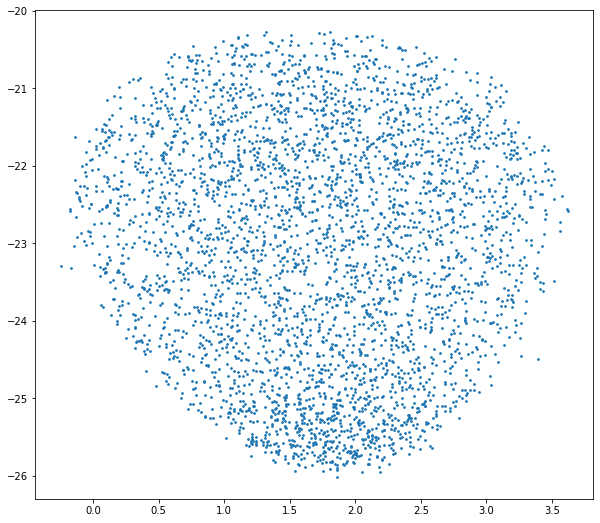

In [ ]:
cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

In [ ]:
def similar_products(v, n = asin_unique):
    
    # extract most similar products for the input vector
    ms = model_wv.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = [j[0], j[1]]
        new_ms.append(pair)
        
    return new_ms  

In [ ]:
list(purchases_val.values())[0][-1]

'B014UMFNIM'

In [ ]:
similar_products(model_wv['B014UMFNIM'])

In [ ]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model_wv[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

In [ ]:
answer_wv = similar_products(aggregate_vectors(list(purchases_val.values())[0]))
answer_wv

In [ ]:
answer_trans_wv = [x[1] for x in answer_wv]
normalized_answer_wv = preprocessing.normalize([answer_trans_wv],norm='max')
normalized_answer_wv =  normalized_answer_wv.reshape(-1)*coeff

In [ ]:
for i in range(len(answer_wv)):
    answer_wv[i][1] = normalized_answer_wv[i]
answer_wv 

[['B014UMFNIM', 0.125],
 ['B00359EXZG', 0.11851646800451247],
 ['B00005OBF2', 0.09809391620837815],
 ['B0050SI9W8', 0.08400250990216823],
 ['B009B0MYSQ', 0.08308251943306282],
 ['B01CZE3NPW', 0.08041405487563025],
 ['B00XJ6WHZ8', 0.07995957613923362],
 ['B0149F5EIE', 0.07756767154226617],
 ['B005WKGZCU', 0.0745102560312368],
 ['B00K7NCS9G', 0.0741738181045027],
 ['B001OAOZ2E', 0.07175422652397459],
 ['B00IZ7QRQG', 0.07087236511005382],
 ['B00IHMFK44', 0.0705349327003079],
 ['B00P20TFWM', 0.07047171096507168],
 ['B00N1O1NQW', 0.06989511980378303],
 ['B017IS057O', 0.06952780966529103],
 ['B000O8I474', 0.06869495176209707],
 ['B00AMBL2BS', 0.06851562053203285],
 ['B01CO2JPYS', 0.06813591538788642],
 ['B00ZZQTP9G', 0.06738640669131986],
 ['B012HG9YYM', 0.06734158289180209],
 ['B00CYT29AY', 0.06725917051699741],
 ['B00E3W19MO', 0.0670115802790502],
 ['B001G4ZA6I', 0.06690601374542711],
 ['B004VC8M3K', 0.06663419559526466],
 ['B00QPWMYDI', 0.06640263959428322],
 ['B00I2P57TO', 0.066171227721

In [ ]:
ratings_df = interactions_selected[["reviewerID", "asin", "overall"]]
ratings_df

In [ ]:
#name = list(purchases_val.keys())[13]
#print(name)
inputMovies = ratings_df[ratings_df["reviewerID"] == "AC3M4JN5I4RDD"]
inputMovies = inputMovies.drop(['reviewerID'], axis=1)
inputMovies

,asin,overall
242,0380812916,4.0
52261,B00002JXBI,5.0
52331,B00002JXBI,3.0
58232,B00004S9AK,5.0
144466,B00005ATZN,4.0


In [ ]:
ratings_df = ratings_df[~ratings_df['reviewerID'].isin(["A3P0KRKOBQK1KN"])]
ratings_df

,reviewerID,asin,overall
0,A1N070NS9CJQ2I,0060009810,5.0
1,A3P0KRKOBQK1KN,0060009810,5.0
2,A192HO2ICJ75VU,0060009810,5.0
3,A2T278FKFL3BLT,0060009810,4.0
4,A2ZUXVTW8RXBXW,0060009810,5.0
...,...,...,...
20994348,A1RH0C7YHWZQER,B01HJF704M,1.0
20994349,A2955VBJEJZ4S,B01HJF704M,5.0
20994350,A1FGCIRPRNZWD5,B01HJF704M,5.0
20994351,AOEG7L8HI8DXJ,B01HJF704M,5.0


In [ ]:
userSubset = ratings_df[ratings_df["asin"].isin(inputMovies["asin"].tolist())]
userSubset

,reviewerID,asin,overall
30332,AMZCZBK1EF1PV,B00000JBLJ,5.0
30333,ASB2KK5C22P6H,B00000JBLJ,5.0
30334,A3IBOQ8R44YG9L,B00000JBLJ,4.0
30336,A1RNNARZ5SF8CC,B00000JBLJ,5.0
30337,A1VQ61UT9WKCV2,B00000JBLJ,1.0
...,...,...,...
17589472,A1JCDG6GWQ47QE,B00005T3HJ,2.0
17589473,AKF5Y2G60SPZR,B00005T3HJ,3.0
17589474,A3SOV46A6CKMRG,B00005T3HJ,1.0
17589475,A2NOFCYST6SFZ3,B00005T3HJ,5.0


In [ ]:
userSubsetGroup = userSubset.groupby(['reviewerID'])
userSubsetGroup

In [ ]:
userSubsetGroup = sorted(userSubsetGroup, key=lambda x: len(x[1]), reverse=True)
userSubsetGroup[0:5]

[('A2MVJNPGTABDCU',               reviewerID        asin  overall
  52373     A2MVJNPGTABDCU  B00002JXBI      5.0
  58169     A2MVJNPGTABDCU  B00004S7NT      5.0
  17564106  A2MVJNPGTABDCU  B000031XD0      1.0),
 ('AC3M4JN5I4RDD',           reviewerID        asin  overall
  52261  AC3M4JN5I4RDD  B00002JXBI      5.0
  52331  AC3M4JN5I4RDD  B00002JXBI      3.0),
 ('A1083TXKCMRLZP',            reviewerID        asin  overall
  38693  A1083TXKCMRLZP  B00001QEMF      4.0),
 ('A11440YU3U1WXZ',            reviewerID        asin  overall
  39090  A11440YU3U1WXZ  B00001QEMF      4.0),
 ('A11730XT410AOF',            reviewerID        asin  overall
  39000  A11730XT410AOF  B00001QEMF      5.0)]

In [ ]:
#userSubsetGroup = userSubsetGroup[0:1230]

In [ ]:
#Store the Pearson Correlation in a dictionary, where the key is the user Id and the value is the coefficient
pearsonCorrelationDict = {}
from math import sqrt
#For every user group in our subset
for name, group in userSubsetGroup:
    #print(name, group, sep = "+")
    #Let’s start by sorting the input and current user group so the values aren’t mixed up later on
    group = group.sort_values(by="asin")
    inputMovies = inputMovies.sort_values(by="asin")
    #Get the N for the formula
    nRatings = len(group)
    #print(nRatings)
    #Get the review scores for the movies that they both have in common
    temp_df = inputMovies[inputMovies["asin"].isin(group["asin"].tolist())]
    #And then store them in a temporary buffer variable in a list format to facilitate future calculations
    tempRatingList = temp_df["overall"].tolist()
    #Let’s also put the current user group reviews in a list format
    tempGroupList = group["overall"].tolist()
    print(tempRatingList, tempGroupList)
    #print("первая штука: ", sum([i**2 for i in tempRatingList]))
    #print("вторая штука: ", pow(sum(tempRatingList),2)/float(nRatings))
    x_mean = sum([i for i in tempRatingList])/nRatings
    y_mean = sum([i for i in tempGroupList])/nRatings

    Sxx = sum([(i-x_mean)**2 for i in tempRatingList])
    Syy = sum([(i-y_mean)**2 for i in tempGroupList])
    Sxy = sum([(i-x_mean)*(j-y_mean) for i, j in zip(tempRatingList, tempGroupList)])

    #Now let’s calculate the pearson correlation between two users, so called, x and y
    #Sxx = sum([i**2 for i in tempRatingList]) - pow(sum(tempRatingList),2)/float(nRatings)
    #Syy = sum([i**2 for i in tempGroupList]) - pow(sum(tempGroupList),2)/float(nRatings)
    #Sxy = sum( i*j for i, j in zip(tempRatingList, tempGroupList)) - sum(tempRatingList)*sum(tempGroupList)/float(nRatings)
    print(Sxx, Syy, Sxy)
    
    #If the denominator is different than zero, then divide, else, 0 correlation.
    if Sxx != 0 and Syy != 0:
        pearsonCorrelationDict[name] = Sxy/sqrt(Sxx*Syy)
        print(Sxy/sqrt(Sxx*Syy))
    else:
        pearsonCorrelationDict[name] = 0


pearsonDF = pd.DataFrame.from_dict(pearsonCorrelationDict, orient='index')
pearsonDF.columns = ['similarityIndex']
pearsonDF['reviewerID'] = pearsonDF.index
pearsonDF.index = range(len(pearsonDF))

listt = pearsonDF['similarityIndex'].to_list()
sum(listt)